In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NAC"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
r = min(5000/len(dataset_), 1)
_, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
#dataset = dataset_
dataset.head()

,id,sequence,length,class
35180,Cotton_A_21044_BGI-A2_v1.0,MYLSEKPRSIDLYKEEGPATASDMIIEVTTNGDLPPHHHHHPPPPQ...,381,0
9631,XP_010108843.1,MPLYSVSEPSALDISEAQGRSTDETFSLRLISWLINSRGLAKKVKN...,1077,1
19759,Zmw_sc05434.1.g00020.1,MLRVRYGGCADGEIERFTLSTPTVHRPQRKSRWPGGIRLVSDLLAL...,426,1
8810,Lj0g3v0198369.1,MRKTLVFYKGRAPNGQKSDWIMHEYRLQTNEHATPQEEGWVVCRVF...,200,1
3597,Carubv10005324m,MTWCNDRNDVQTVERIIPSPTAAESPRASLPVSSHKTCPSCGHNFK...,307,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1612,0.012766,0.000000,0.004255,0.004255,0.000000,0.000000,0.0,0.000000,0.000000,0.008511,...,0.004255,0.000000,0.004255,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4360,0.002915,0.000000,0.005831,0.001458,0.002915,0.005831,0.0,0.002915,0.002915,0.005831,...,0.000000,0.002915,0.000000,0.002915,0.0,0.0,0.001458,0.001458,0.0,0.001458
2918,0.000000,0.013029,0.000000,0.003257,0.000000,0.000000,0.0,0.003257,0.009772,0.000000,...,0.000000,0.003257,0.000000,0.003257,0.0,0.0,0.000000,0.006515,0.0,0.000000
4536,0.004329,0.004329,0.004329,0.000000,0.000000,0.004329,0.0,0.004329,0.004329,0.004329,...,0.000000,0.000000,0.004329,0.004329,0.0,0.0,0.004329,0.008658,0.0,0.000000
2941,0.003448,0.000000,0.003448,0.003448,0.003448,0.017241,0.0,0.003448,0.006897,0.003448,...,0.000000,0.000000,0.003448,0.003448,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 28s 579ms/step - accuracy: 0.4375 - loss: 0.6939

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6064 - loss: 0.6857   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6526 - loss: 0.6679 - val_accuracy: 0.9438 - val_loss: 0.3078


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.3001

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9489 - loss: 0.2198

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9489 - loss: 0.2060 - val_accuracy: 0.9563 - val_loss: 0.1059


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.1549

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 0.0832

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0848 - val_accuracy: 0.9588 - val_loss: 0.1065


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0992

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0779 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0738 - val_accuracy: 0.9625 - val_loss: 0.0925


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0357

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0605 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0610 - val_accuracy: 0.9675 - val_loss: 0.1011


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9219 - loss: 0.1899

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9805 - loss: 0.0639 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0577 - val_accuracy: 0.9700 - val_loss: 0.0992


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0132

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0405

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0417 - val_accuracy: 0.9737 - val_loss: 0.0841


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0293

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0305 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0304 - val_accuracy: 0.9700 - val_loss: 0.1016


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.0758

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0362

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0378 - val_accuracy: 0.9588 - val_loss: 0.1310


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.0956

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.0506 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0455 - val_accuracy: 0.9750 - val_loss: 0.0917


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0293

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0309

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0311 - val_accuracy: 0.9712 - val_loss: 0.0961


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0041

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0238

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0239 - val_accuracy: 0.9613 - val_loss: 0.1405


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0481

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0360 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0418 - val_accuracy: 0.9525 - val_loss: 0.1809


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0490

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0329 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0290 - val_accuracy: 0.9650 - val_loss: 0.1160


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0209

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0203

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0205 - val_accuracy: 0.9688 - val_loss: 0.1082


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0848

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0241

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0198 - val_accuracy: 0.9688 - val_loss: 0.1109


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0025

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0161 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0152 - val_accuracy: 0.9700 - val_loss: 0.1096


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0020

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0093

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9712 - val_loss: 0.1331


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0063

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0077

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9575 - val_loss: 0.1413


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0193

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0063

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0067 - val_accuracy: 0.9588 - val_loss: 0.1499



[Train Accuracy: 99.69% - Test Accuracy: 96.30%]


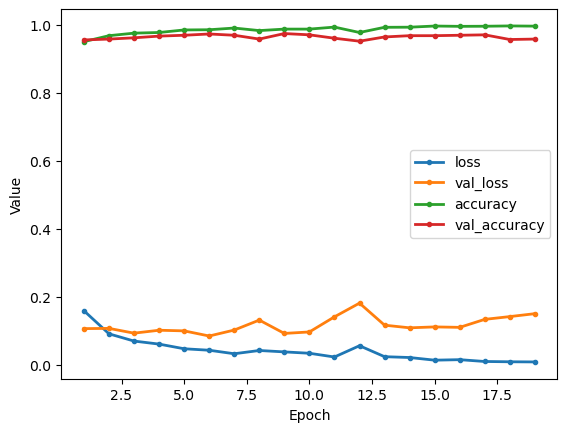

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1612,0.0,0.0,0.0,0.004274,0.0,0.0,0.0,0.0,0.0,0.004274,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4360,0.0,0.0,0.0,0.001460,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00146,0.0,0.0,0.0,0.0,0.0,0.0
2918,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4536,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2941,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8755)
X_test: (1000, 8755)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,241,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,284,801 (8.72 MB)

 Trainable params: 2,284,801 (8.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 600ms/step - accuracy: 0.3906 - loss: 0.6932

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4877 - loss: 0.6931   

14/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5010 - loss: 0.6930

21/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5340 - loss: 0.6924

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5736 - loss: 0.6909

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6059 - loss: 0.6879

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6325 - loss: 0.6821

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6498 - loss: 0.6754 - val_accuracy: 0.9638 - val_loss: 0.3328


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.3227

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9721 - loss: 0.2731 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9689 - loss: 0.2441

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9694 - loss: 0.2195

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9707 - loss: 0.1990

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9720 - loss: 0.1826

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9733 - loss: 0.1690

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9736 - loss: 0.1661 - val_accuracy: 0.9887 - val_loss: 0.0420


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0110

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0131 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0114

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0103

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0095

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0090

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0086

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0085 - val_accuracy: 0.9862 - val_loss: 0.0387


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0029

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0040 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0037

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0034

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0031

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0030

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9887 - val_loss: 0.0426


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.3238e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9618e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0523e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9396e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7542e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7596e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7571e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7601e-04 - val_accuracy: 0.9887 - val_loss: 0.0426


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0012

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9024e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0274e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6122e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2354e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9381e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7272e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6797e-04 - val_accuracy: 0.9887 - val_loss: 0.0493


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.8283e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4405e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0944e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9237e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9133e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9172e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9324e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9465e-04 - val_accuracy: 0.9887 - val_loss: 0.0458


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.7984e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4089e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3789e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4309e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5875e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6895e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8035e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8258e-04 - val_accuracy: 0.9887 - val_loss: 0.0523


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0014

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0955e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4146e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0295e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7792e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6212e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5228e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4967e-04 - val_accuracy: 0.9862 - val_loss: 0.0448


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3942e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4649e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5875e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5495e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5377e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6770e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9628e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0491e-04 - val_accuracy: 0.9900 - val_loss: 0.0510


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0205e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7194e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6422e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4135e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2517e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1258e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0190e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0006e-04 - val_accuracy: 0.9887 - val_loss: 0.0538


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.2805e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4229e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2973e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2456e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2057e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1603e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1186e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1097e-04 - val_accuracy: 0.9875 - val_loss: 0.0619


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3836e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8976e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6535e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6431e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1594e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3930e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5003e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5748e-05 - val_accuracy: 0.9887 - val_loss: 0.0597


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.0072e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4763e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1422e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0633e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0383e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0053e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6791e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5871e-05 - val_accuracy: 0.9887 - val_loss: 0.0593


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.3378e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0134e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9693e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4456e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9285e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4907e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1787e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.1108e-05 - val_accuracy: 0.9887 - val_loss: 0.0602


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5126e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9676e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9429e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2522e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6864e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2512e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9063e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8282e-05 - val_accuracy: 0.9887 - val_loss: 0.0618


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.3775e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2518e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6997e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6399e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1662e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1906e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0255e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.9811e-05 - val_accuracy: 0.9887 - val_loss: 0.0658


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.4188e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4789e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2789e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2044e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0729e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0763e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0848e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0820e-05 - val_accuracy: 0.9887 - val_loss: 0.0635


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.9513e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8610e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9512e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5447e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8597e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9956e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0700e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0821e-05 - val_accuracy: 0.9887 - val_loss: 0.0662


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.5330e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7704e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0496e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4608e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7035e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7999e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8273e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8380e-05 - val_accuracy: 0.9887 - val_loss: 0.0670



[Train Accuracy: 100.00% - Test Accuracy: 99.20%]


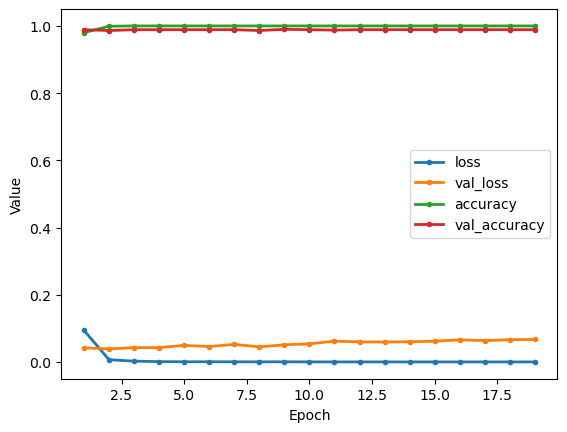

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYY
1612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,458,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,499,393 (143.05 MB)

 Trainable params: 37,499,393 (143.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - accuracy: 0.5312 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.4883 - loss: 0.6934 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.4818 - loss: 0.6934

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.4834 - loss: 0.6934

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.4930 - loss: 0.6933

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5007 - loss: 0.6933

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5041 - loss: 0.6933

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5053 - loss: 0.6932

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5078 - loss: 0.6932

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5106 - loss: 0.6931

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5150 - loss: 0.6931

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5194 - loss: 0.6930

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5230 - loss: 0.6929

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5262 - loss: 0.6928

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5289 - loss: 0.6927

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5313 - loss: 0.6926

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5341 - loss: 0.6925

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5372 - loss: 0.6924

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5408 - loss: 0.6923

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5448 - loss: 0.6922

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5486 - loss: 0.6921

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5524 - loss: 0.6919

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5564 - loss: 0.6918

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5604 - loss: 0.6916

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5646 - loss: 0.6914

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5687 - loss: 0.6912

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5729 - loss: 0.6910

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5771 - loss: 0.6908

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5813 - loss: 0.6906

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5855 - loss: 0.6903

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5896 - loss: 0.6900

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5938 - loss: 0.6897

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5979 - loss: 0.6894

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6018 - loss: 0.6890

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6057 - loss: 0.6887

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6094 - loss: 0.6883

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6130 - loss: 0.6879

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6166 - loss: 0.6875

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6202 - loss: 0.6870

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6238 - loss: 0.6865

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6272 - loss: 0.6859

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6306 - loss: 0.6854

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6340 - loss: 0.6848

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6373 - loss: 0.6841

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6405 - loss: 0.6834

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6437 - loss: 0.6827

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6468 - loss: 0.6819

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6498 - loss: 0.6811

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6528 - loss: 0.6802

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6557 - loss: 0.6793

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.6585 - loss: 0.6784 - val_accuracy: 0.9850 - val_loss: 0.4182


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.9844 - loss: 0.3768

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9883 - loss: 0.3770 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9887 - loss: 0.3768

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9876 - loss: 0.3725

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9864 - loss: 0.3677

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9847 - loss: 0.3628

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9840 - loss: 0.3580

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9833 - loss: 0.3537

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9829 - loss: 0.3494

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9827 - loss: 0.3452

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9826 - loss: 0.3410

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9825 - loss: 0.3366

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9826 - loss: 0.3321

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9825 - loss: 0.3278

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9823 - loss: 0.3235

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9822 - loss: 0.3193

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9822 - loss: 0.3151

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9821 - loss: 0.3111

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9820 - loss: 0.3071

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9820 - loss: 0.3033

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9819 - loss: 0.2995

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9819 - loss: 0.2959

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9818 - loss: 0.2924

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9818 - loss: 0.2889

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9818 - loss: 0.2855

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9818 - loss: 0.2822

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9819 - loss: 0.2790

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9819 - loss: 0.2758

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9820 - loss: 0.2727

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9821 - loss: 0.2696

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9821 - loss: 0.2666

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9822 - loss: 0.2637

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9823 - loss: 0.2608

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9824 - loss: 0.2580

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9825 - loss: 0.2553

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9826 - loss: 0.2526

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9827 - loss: 0.2500

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9828 - loss: 0.2474

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9829 - loss: 0.2450

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9830 - loss: 0.2425

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9831 - loss: 0.2402

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9832 - loss: 0.2379

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9832 - loss: 0.2356

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9833 - loss: 0.2334

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9834 - loss: 0.2313

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9835 - loss: 0.2291

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9835 - loss: 0.2271

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9836 - loss: 0.2250

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9837 - loss: 0.2231

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9838 - loss: 0.2211

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9839 - loss: 0.2193 - val_accuracy: 0.9937 - val_loss: 0.0700


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 1.0000 - loss: 0.0187

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0173 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 0.0161

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0150

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 0.0142

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 0.0134

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0127

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 0.0122

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0117

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0113

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 0.0109

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9999 - loss: 0.0107

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9998 - loss: 0.0105

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9997 - loss: 0.0103

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9997 - loss: 0.0101

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9996 - loss: 0.0100

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9996 - loss: 0.0098

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9996 - loss: 0.0097

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9996 - loss: 0.0095

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9995 - loss: 0.0094

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9995 - loss: 0.0093

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9995 - loss: 0.0091

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9995 - loss: 0.0090

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9995 - loss: 0.0089

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9995 - loss: 0.0088

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9995 - loss: 0.0087

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9995 - loss: 0.0086

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9995 - loss: 0.0085

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9995 - loss: 0.0084

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9995 - loss: 0.0084

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9995 - loss: 0.0083

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9995 - loss: 0.0082

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9995 - loss: 0.0081

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9995 - loss: 0.0081

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0080

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0079

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0079

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0078

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0077

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0077

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0076

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9995 - loss: 0.0075

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0075

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0074

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0074

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0073

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0073

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0072

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0071

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.0071

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9995 - loss: 0.0070 - val_accuracy: 0.9850 - val_loss: 0.0480


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 1.0000 - loss: 0.0023

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0020 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 0.0018

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0018

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0018

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0019

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0019

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0020

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0020

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0021

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0021

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0021

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0021

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0021

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0021

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0021

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0020

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0020

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0020

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0019

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0019

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0019

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0018

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0018

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0018

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0018

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0018

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0017

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0017

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0017

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0017

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9850 - val_loss: 0.0479


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 1.0000 - loss: 7.7814e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 9.7368e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.6498e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.3869e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.2646e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.0757e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.8375e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.7725e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.6911e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.7070e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.7863e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.8453e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.8772e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 8.8981e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 9.0145e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 9.0959e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 9.1631e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2089e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2382e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2535e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2631e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2607e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2530e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2452e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.2353e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.2205e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.2007e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.1815e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.1588e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.1347e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.1072e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.0796e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.0512e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 9.0201e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.9892e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 8.9580e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.9276e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.8964e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.8656e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.8330e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.7993e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.7657e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.7362e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.7094e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.6813e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.6543e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.6279e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.6021e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.5762e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.5499e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 8.5247e-04 - val_accuracy: 0.9850 - val_loss: 0.0477


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 1.0000 - loss: 7.2230e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.4642e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 6.1296e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 5.9523e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 5.7583e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.6099e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.4905e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.3817e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.2653e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.1553e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.0713e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.9990e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.9443e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.8852e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.8273e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.7750e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.7277e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.6798e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6328e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.5895e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.5510e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.5171e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.4831e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.4525e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.4245e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.3950e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.3661e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.3425e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.3225e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.3020e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.2811e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.2612e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.2415e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.2227e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.2058e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1893e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1725e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1553e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1378e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1199e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1034e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.0875e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.0730e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.0591e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 4.0453e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 4.0316e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 4.0178e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 4.0057e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.9935e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 3.9826e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 3.9721e-04 - val_accuracy: 0.9850 - val_loss: 0.0489


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 1.0000 - loss: 1.1147e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.6764e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.1876e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.3873e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.4615e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.4848e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.5463e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 2.7232e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.9544e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 3.1025e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 3.2066e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 3.2898e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 3.3506e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.4357e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 3.5051e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 3.5606e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.6027e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 3.6324e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.6515e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.6639e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.6748e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.6798e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.6800e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 3.6774e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.6723e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 3.6686e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 3.6661e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.6613e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.6547e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.6461e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.6358e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 3.6241e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 3.6116e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.5986e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.5853e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.5723e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 3.5593e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.5462e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.5335e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 3.5202e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 3.5079e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.4962e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.4854e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.4748e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.4644e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.4537e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.4429e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.4320e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.4210e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.4101e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.3996e-04 - val_accuracy: 0.9837 - val_loss: 0.0504


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 3.0325e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6193e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.4163e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.4842e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4461e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.3988e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.3373e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.3236e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.3050e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.2824e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.2578e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2418e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2208e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2041e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.1882e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.1732e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.1824e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1902e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1945e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1958e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 2.1954e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1928e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1888e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1858e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1828e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1794e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1770e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1735e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1698e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1664e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1625e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1582e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1530e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1473e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1406e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1341e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1273e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.1202e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1128e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1053e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0977e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.0909e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.0847e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0788e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.0729e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0668e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0613e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0557e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0502e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0446e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.0393e-04 - val_accuracy: 0.9837 - val_loss: 0.0514


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 1.0000 - loss: 1.2085e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.3845e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.4592e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4628e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4869e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4788e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4945e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4971e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4918e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4806e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4678e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4728e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4798e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4870e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4888e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4888e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4863e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4832e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4789e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4822e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4870e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4900e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4920e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4933e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4931e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4919e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4967e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4999e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5038e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.5068e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5119e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5168e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5214e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.5260e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5295e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5323e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5355e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5380e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5403e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5432e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5464e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.5515e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5560e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5612e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5654e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.5695e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5738e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5774e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5806e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.5841e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.5875e-04 - val_accuracy: 0.9850 - val_loss: 0.0464


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 1.1078e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.0433e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.9729e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.5792e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.7714e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8119e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8038e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7695e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.8091e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.8156e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.8019e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.7707e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7367e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6949e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6487e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6004e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.5534e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.5057e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.4582e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.4153e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.3726e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.3320e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.2918e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.2523e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.2135e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.1757e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.1400e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.1060e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.0727e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.0423e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.0135e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.9852e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.9579e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.9309e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.9044e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.8782e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.8527e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.8279e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.8039e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7803e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7576e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7353e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7134e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.6924e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.6724e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.6528e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.6334e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.6144e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5959e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5778e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.5605e-04 - val_accuracy: 0.9875 - val_loss: 0.0411


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 1.0000 - loss: 7.5110e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 1.0000 - loss: 7.3051e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.0080e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 6.9609e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.3570e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.6516e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 7.8638e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.9602e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 8.0790e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 8.1969e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.2632e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.3258e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 8.3530e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 8.3872e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 8.4095e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 8.4263e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 8.4316e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 8.4422e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 8.4459e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.4434e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 8.4425e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.4530e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.4646e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.4693e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.4940e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.5117e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.5221e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.5307e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.5343e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.5311e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 8.5302e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5283e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5336e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5434e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5522e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5604e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5760e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.5891e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.6006e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.6124e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.6217e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.6307e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6380e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6434e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6472e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6494e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6500e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6485e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6457e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 8.6424e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 8.6392e-05 - val_accuracy: 0.9837 - val_loss: 0.0531


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.8022e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.3742e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.0089e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.6302e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.0161e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.4037e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.6181e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.7287e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.9244e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.0310e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.0878e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.1294e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.1702e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.2183e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.2500e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.2841e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.3073e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.3891e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.4858e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.5816e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6661e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.7366e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7933e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8448e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.8891e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.9250e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.9530e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.9752e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.9942e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.0396e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.0784e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.1200e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.1561e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.1851e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.2134e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.2371e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.2597e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.2823e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.3013e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.3188e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.3350e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.3487e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3590e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3681e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3752e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3810e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3868e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3915e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.3960e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.4001e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 7.4040e-05 - val_accuracy: 0.9850 - val_loss: 0.0474



[Train Accuracy: 100.00% - Test Accuracy: 99.10%]


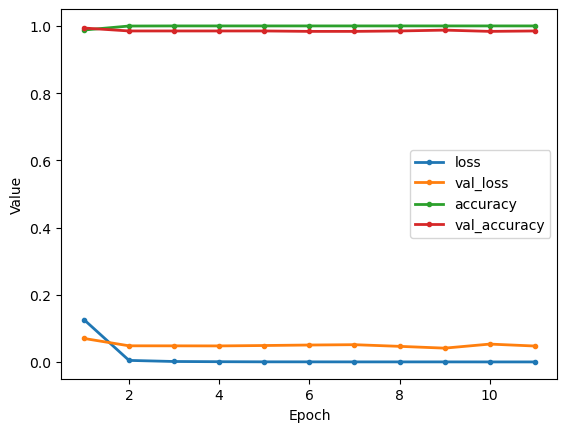

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/NAC/report_CGCD2KSD.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################